<a href="https://colab.research.google.com/github/amirkasaei/Kidney-Renal-Cancer-Classification/blob/main/Kidney_Renal_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [67]:
# imports
import glob
import cv2
import random
import copy
import time
import numpy as np

import torch
import torch.nn as nn
from tqdm.auto import tqdm, trange
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
# from torchvision import transforms
import torchvision


import matplotlib.pyplot as plt
from PIL import Image
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import pandas as pd
import shutil
import os

# Configs

In [2]:
torch.cuda.empty_cache()
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# Load Data

In [4]:
import gdown

url = 'https://drive.google.com/uc?id=1_KBQVPseZcKE6yte0aVTnBLn3rgiUKyA'

output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1_KBQVPseZcKE6yte0aVTnBLn3rgiUKyA
From (redirected): https://drive.google.com/uc?id=1_KBQVPseZcKE6yte0aVTnBLn3rgiUKyA&confirm=t&uuid=2f9880bb-f8e0-429c-b381-6f604dbcdff2
To: /content/dataset.zip
100%|██████████| 173M/173M [00:03<00:00, 50.5MB/s]


'dataset.zip'

In [5]:
! unzip -q dataset.zip

In [6]:
classes = {
    'AML (fat reach)': 0,
    'Chromophobe RCC': 1,
    'Clear Cell RCC': 2,
    'High Grade Urothelial Papillary Carcinoma': 3,
    'Hydatid Cyst': 4,
    'Low Grade Papillary Urothelial Carcinoma': 5,
    'Multilucolar Cystic Renal Neoplasm of Low Malignant': 6,
    'Papillary RCC type 1': 7,
    'Papillary RCC type 2': 8,
    'Sarcomatoid RCC': 9,
    'SCC': 10,
    'Simple Cyst': 11,
}

In [7]:
def create_dataset(path):
  dataset = {
      'image_path': [],
      'class_name': [],
      'label': []
  }
  for image_path in glob.iglob(path + '/**/*.png'):
    class_name = image_path.split('/')[-2]
    dataset['image_path'].append(image_path)
    dataset['class_name'].append(class_name)
    dataset['label'].append(classes[class_name])

  return dataset

In [8]:
p = '/content/Rencal Cancer merged/With Contrastive agent'
data = create_dataset(p)

In [9]:
dataframe = pd.DataFrame(data)
dataframe.head()

,image_path,class_name,label
0,/content/Rencal Cancer merged/With Contrastive...,Papillary RCC type 2,8
1,/content/Rencal Cancer merged/With Contrastive...,Papillary RCC type 2,8
2,/content/Rencal Cancer merged/With Contrastive...,Papillary RCC type 2,8
3,/content/Rencal Cancer merged/With Contrastive...,Papillary RCC type 2,8
4,/content/Rencal Cancer merged/With Contrastive...,Papillary RCC type 2,8


In [41]:
class_counts = dataframe['class_name'].value_counts(sort=True)
print(class_counts)

Clear Cell RCC                               111
Sarcomatoid RCC                               19
Simple Cyst                                   18
AML (fat reach)                               13
SCC                                            9
High Grade Urothelial Papillary Carcinoma      7
Hydatid Cyst                                   7
Papillary RCC type 2                           6
Low Grade Papillary Urothelial Carcinoma       3
Chromophobe RCC                                3
Papillary RCC type 1                           3
Name: class_name, dtype: int64


In [11]:
classes = class_counts[class_counts >= 10].index
classes

Index(['Clear Cell RCC', 'Sarcomatoid RCC', 'Simple Cyst', 'AML (fat reach)'], dtype='object')

In [12]:
dataframe_filtered = dataframe[dataframe.class_name.isin(classes)]
dataframe_filtered.head()

,image_path,class_name,label
6,/content/Rencal Cancer merged/With Contrastive...,Clear Cell RCC,2
7,/content/Rencal Cancer merged/With Contrastive...,Clear Cell RCC,2
8,/content/Rencal Cancer merged/With Contrastive...,Clear Cell RCC,2
9,/content/Rencal Cancer merged/With Contrastive...,Clear Cell RCC,2
10,/content/Rencal Cancer merged/With Contrastive...,Clear Cell RCC,2


In [43]:
dataframe_filtered['class_name'].value_counts()

Clear Cell RCC     111
Sarcomatoid RCC     19
Simple Cyst         18
AML (fat reach)     13
Name: class_name, dtype: int64

In [44]:
for i in range(len(classes)):
  class_indicies = dataframe_filtered['class_name'] == classes[i]
  dataframe_filtered.loc[class_indicies, 'label'] = i

In [52]:
dataframe_filtered.head()

,image_path,class_name,label
6,/content/Rencal Cancer merged/With Contrastive...,Clear Cell RCC,0
7,/content/Rencal Cancer merged/With Contrastive...,Clear Cell RCC,0
8,/content/Rencal Cancer merged/With Contrastive...,Clear Cell RCC,0
9,/content/Rencal Cancer merged/With Contrastive...,Clear Cell RCC,0
10,/content/Rencal Cancer merged/With Contrastive...,Clear Cell RCC,0


# Dataset and Dataloader

In [88]:
class RencalCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.dataframe = df
        self.trasnform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):

        image_path, label = self.dataframe[['image_path', 'label']].iloc[index]

        image = cv2.imread(image_path)
        # image = Image.open(image_path)
        image = self.trasnform(image)

        return image, label

In [89]:
train_data, test_data = train_test_split(dataframe_filtered, test_size=0.2, random_state=42)

In [90]:
train_data.head()

,image_path,class_name,label
131,/content/Rencal Cancer merged/With Contrastive...,Simple Cyst,2
8,/content/Rencal Cancer merged/With Contrastive...,Clear Cell RCC,0
139,/content/Rencal Cancer merged/With Contrastive...,Simple Cyst,2
51,/content/Rencal Cancer merged/With Contrastive...,Clear Cell RCC,0
48,/content/Rencal Cancer merged/With Contrastive...,Clear Cell RCC,0


In [91]:
train_data['class_name'].value_counts()

Clear Cell RCC     85
Simple Cyst        17
Sarcomatoid RCC    15
AML (fat reach)    11
Name: class_name, dtype: int64

In [92]:
datasets = {}
phases = ['train', 'valid', 'test']

In [93]:
PILimage = T.Compose([
    T.ToPILImage()
])

transformers = [
    T.functional.vflip,
    T.functional.hflip,
    # T.RandomRotation((90, 90)),
    # T.RandomRotation((180, 180)),
    # T.RandomRotation((270, 270))
]


randomAug = T.RandomApply([T.RandomChoice(transformers)], p=0.5)

train_transformations = T.Compose([
    T.ToPILImage(),
    T.CenterCrop((820, 900)),
    T.Resize((224 , 224)),
    T.RandomApply([T.RandomChoice(transformers)], p=0.5),
    T.ToTensor(),
])

test_transformations = T.Compose([
    T.ToPILImage(),
    T.CenterCrop((820, 900)),
    T.Resize((224 , 224)),
    T.ToTensor(),
])

In [94]:
datasets['train'] = RencalCancerDataset(train_data, train_transformations)
datasets['test'] = RencalCancerDataset(test_data, test_transformations)

In [95]:
datasets['train'][10][0].shape

torch.Size([3, 224, 224])

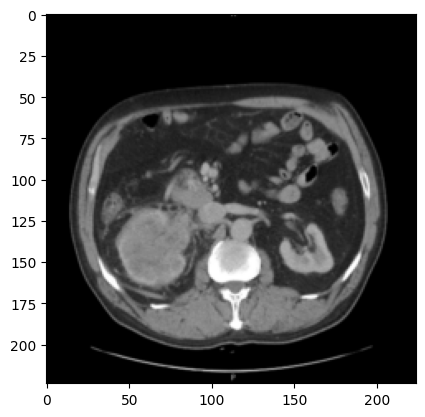

In [96]:
plt.imshow(PILimage(datasets['test'][10][0]))

In [97]:
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'], shuffle=True, batch_size=32)
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], shuffle=False, batch_size=32)

# Train

In [98]:
def one_epoch(model, loader, criterion, optimizer, scheduler, device, phase):

  if phase == 'train':
    model.train() # Set model to training mode
  else:
    model.eval()

  running_loss = 0.0
  running_accuracy = 0.0
  running_precision = 0.0
  running_recall = 0.0
  running_f1_score = 0.0

  # Iterate over data.
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    with torch.set_grad_enabled(phase == 'train'):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

      if phase == 'train':
        loss.backward()
        optimizer.step()

    # statistics
    running_loss += loss.item()
    running_accuracy += sklearn.metrics.accuracy_score(labels.cpu(), preds.cpu())
    running_precision += sklearn.metrics.precision_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    running_recall += sklearn.metrics.recall_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    running_f1_score += sklearn.metrics.f1_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)

    if phase == 'train' and  scheduler:
        scheduler.step()

  loss = running_loss / len(loader)
  accuracy = running_accuracy / len(loader)
  precision = running_precision / len(loader)
  recall = running_recall / len(loader)
  f1_score = running_f1_score / len(loader)

  return loss, accuracy, precision, recall, f1_score

In [99]:
def train(model, loaders, criterion, optimizer, num_epochs, device, scheduler=None):

  best_val_loss = float('inf')
  best_val_acc = 0
  # best_model = None

  accuracy_dic, loss_dic = {}, {}
  loss_dic['train'], loss_dic['validation'] = [], []
  accuracy_dic['train'], accuracy_dic['validation'] = [], []

  for epoch in range(num_epochs):
      train_loss, train_acc, train_precision, train_recall, train_f1 = one_epoch(model, loaders['train'], criterion, optimizer, scheduler, device, phase='train' )
      # val_loss, val_acc, val_precision, val_recall, val_f1 = one_epoch(model, loaders['validation'], criterion, optimizer, scheduler, device, phase='validation')

      loss_dic['train'].append(train_loss)
      # loss_dic['validation'].append(val_loss)
      accuracy_dic['train'].append(train_acc)
      # accuracy_dic['validation'].append(val_acc)

      # if val_loss < best_val_loss:
      #   best_val_acc = val_acc
      #   best_val_loss = val_loss
      #   # best_model = model.state_dict()
      #   torch.save(model.state_dict(), model_path)


      print(f'Epoch [{epoch+1}/{num_epochs}] - '
            f'Train Loss: {train_loss:.4f} - '
            f'Train Accuracy: {train_acc:.4f} - '
            f'Train Precision {train_precision:.4f} - '
            f'Train Recall {train_recall:.4f} - '
            f'Train F1-score {train_f1:.4f} ')
            # f'Validation Loss: {val_loss:.4f} - '
            # f'Validation Accuracy {val_acc:.4f} - '
            # f'Validation Precision {val_precision:.4f} - '
            # f'Validation Recall {val_recall:.4f} - '
            # f'Validation F1-score {val_f1:.4f} ')

  return loss_dic, accuracy_dic

In [100]:
def evaluate(model, loaders, criterion, optimizer, device, phase, scheduler=None):

  loss, accuracy, precision, recall, f1_score = one_epoch(model, loaders[phase], criterion, optimizer, scheduler, device, 'test')

  print(f'{phase} Loss: {loss:.4f} - '
        f'{phase} Acuracy {accuracy:.2f} - '
        f'{phase} Precision: {precision:.2f} - '
        f'{phase} Recall {recall:.2f} - '
        f'{phase} F1: {f1_score:.2f}')


In [101]:
def show_plots(num_epochs, data, metric):
  e = np.arange(num_epochs)
  plt.plot(e, data['train'], label='train '+metric)
  # plt.plot(e, data['valid'], label='validation '+metric)
  plt.xlabel('epoch')
  plt.ylabel(metric)
  plt.legend()

In [102]:
def plot_confusionmatrix(y_pred, y_true, classes):
  print('Confusion matrix')
  cf = sklearn.metrics.confusion_matrix(y_pred, y_true)
  sns.heatmap(cf,annot=True,yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='g')
  plt.tight_layout()
  plt.show()

In [103]:
def report(model, loader, device, classes):

  # Each epoch has a training and validation phase
  model.eval()   # Set model to evaluate mode

  y_pred = []
  y_true = []

  # Iterate over data.
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.type(torch.LongTensor)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      y_pred.extend(preds.cpu())
      y_true.extend(labels)

  plot_confusionmatrix(y_pred, y_true, classes)

In [ ]:
model = torchvision.models.alexnet(pretrained=True)
input_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features=input_features, out_features=len(classes), bias=True)

model.to(device)

In [111]:
classes

Index(['Clear Cell RCC', 'Sarcomatoid RCC', 'Simple Cyst', 'AML (fat reach)'], dtype='object')

In [115]:
class_weights=compute_class_weight('balanced', classes=classes, y=train_data['class_name'])
class_weights = torch.FloatTensor(class_weights).to(device)
class_weights

tensor([0.3765, 2.1333, 1.8824, 2.9091], device='cuda:0')

In [123]:
model_path = '/content'

In [116]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

num_epochs = 100

In [117]:
loss_dic, accuracy_dic = train(model, dataloaders, criterion, optimizer, num_epochs, device, scheduler=None)

Epoch [1/100] - Train Loss: 6125.6829 - Train Accuracy: 0.1875 - Train Precision 0.0941 - Train Recall 0.1875 - Train F1-score 0.1169 
Epoch [2/100] - Train Loss: 73.1603 - Train Accuracy: 0.2656 - Train Precision 0.3312 - Train Recall 0.2656 - Train F1-score 0.2662 
Epoch [3/100] - Train Loss: 24.2337 - Train Accuracy: 0.3359 - Train Precision 0.3504 - Train Recall 0.3359 - Train F1-score 0.2767 
Epoch [4/100] - Train Loss: 10.2349 - Train Accuracy: 0.2109 - Train Precision 0.2347 - Train Recall 0.2109 - Train F1-score 0.1647 
Epoch [5/100] - Train Loss: 1.7087 - Train Accuracy: 0.2422 - Train Precision 0.4165 - Train Recall 0.2422 - Train F1-score 0.2023 
Epoch [6/100] - Train Loss: 1.5453 - Train Accuracy: 0.1953 - Train Precision 0.1100 - Train Recall 0.1953 - Train F1-score 0.1298 
Epoch [7/100] - Train Loss: 36.1568 - Train Accuracy: 0.4297 - Train Precision 0.3978 - Train Recall 0.4297 - Train F1-score 0.4073 
Epoch [8/100] - Train Loss: 1.9116 - Train Accuracy: 0.1562 - Train P

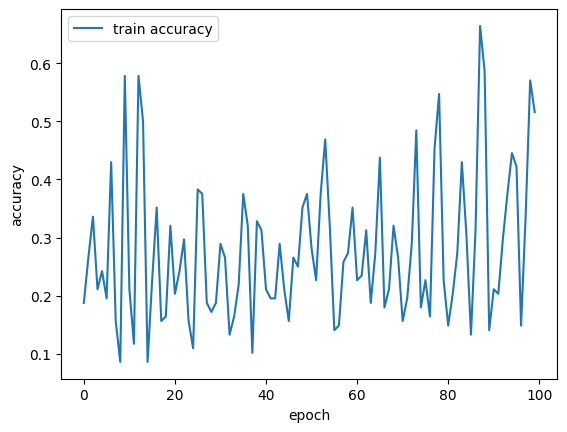

In [118]:
show_plots(num_epochs, accuracy_dic, 'accuracy')

In [ ]:
model.load_state_dict(torch.load(model_path))

In [124]:
evaluate(model, dataloaders, criterion, optimizer, device, 'train')

train Loss: 1.3862 - train Acuracy 0.66 - train Precision: 0.45 - train Recall 0.66 - train F1: 0.53


Confusion matrix


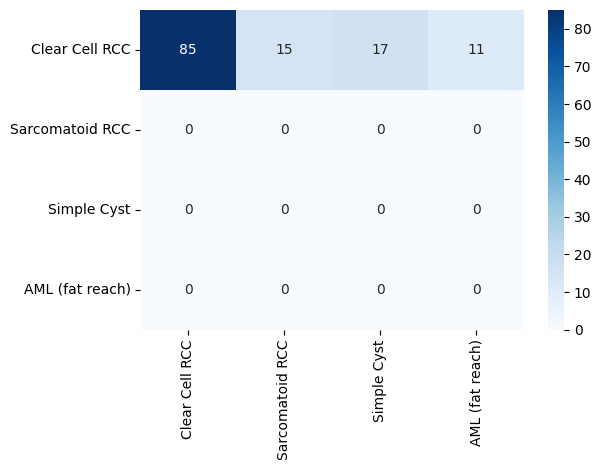

In [125]:
report(model, dataloaders['train'], device, classes)

In [126]:
evaluate(model, dataloaders, criterion, optimizer, device, 'test')

test Loss: 1.3790 - test Acuracy 0.89 - test Precision: 0.81 - test Recall 0.89 - test F1: 0.84


Confusion matrix


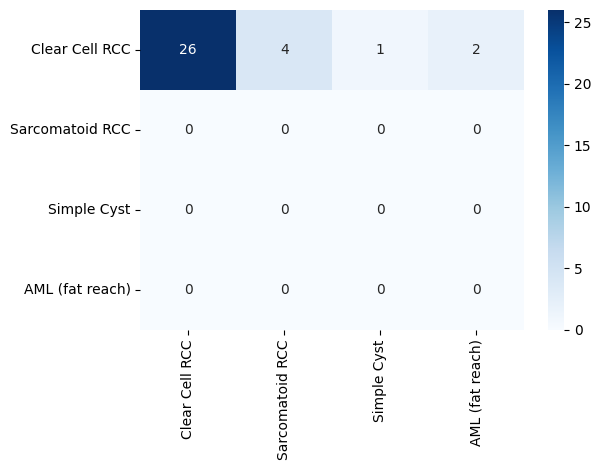

In [127]:
report(model, dataloaders['test'], device, classes)